In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test39.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test58.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test82.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test94.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test35.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test75.tif
/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset/ICIAR2018_BACH_Challenge_TestDataset/Photos/test52.tif
/kaggl

In [7]:
# Cell 2: Installs and imports
# Install timm for models if not present
!pip -q install timm==1.0.9 --no-input

import random, shutil, math, time
from pathlib import Path
from collections import defaultdict
from typing import Tuple, List, Dict
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Optional: stain normalization (try to import staintools if available)
try:
    import staintools
    STAINTOOLS_AVAILABLE = True
except Exception:
    STAINTOOLS_AVAILABLE = False

# Reproducibility
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [8]:
# Cell 3: Dataset location and quick discovery
# Adjust this path if your dataset sits elsewhere in the /kaggle/input tree
DATA_ROOT = Path("/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos")
assert DATA_ROOT.exists(), f"Dataset folder not found: {DATA_ROOT}"
classes = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Classes:", classes)

# Count images
EXTS = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
counts = {c: len(list((DATA_ROOT/c).glob("*"))) for c in classes}
print("Counts per class (raw):", counts)


Classes: ['Benign', 'InSitu', 'Invasive', 'Normal']
Counts per class (raw): {'Benign': 101, 'InSitu': 101, 'Invasive': 101, 'Normal': 101}


In [9]:
# Cell 4: Build DataFrame of all images
rows = []
for cid, cname in enumerate(classes):
    for p in (DATA_ROOT/cname).iterdir():
        if p.suffix.lower() in EXTS and p.is_file():
            rows.append((str(p), cid, cname))
df = pd.DataFrame(rows, columns=["path","label","label_name"])
print("Total images discovered:", len(df))
df.label_name.value_counts()


Total images discovered: 400


label_name
Benign      100
InSitu      100
Invasive    100
Normal      100
Name: count, dtype: int64

In [10]:
# Cell 5: Create train/test split with exactly 100 test images (25 per class)
TEST_PER_CLASS = 25
assert all(df['label_name'].value_counts() >= TEST_PER_CLASS), "Not enough images per class for requested test size"

train_idx = []
test_idx = []
for cls_name, g in df.groupby("label_name"):
    idxs = g.index.tolist()
    random.shuffle(idxs)
    test_idx += idxs[:TEST_PER_CLASS]
    train_idx += idxs[TEST_PER_CLASS:]

df_train = df.loc[train_idx].reset_index(drop=True)
df_test  = df.loc[test_idx].reset_index(drop=True)
print("train:", len(df_train), "test:", len(df_test))
print(df_train.label_name.value_counts())
print(df_test.label_name.value_counts())


train: 300 test: 100
label_name
Benign      75
InSitu      75
Invasive    75
Normal      75
Name: count, dtype: int64
label_name
Benign      25
InSitu      25
Invasive    25
Normal      25
Name: count, dtype: int64


In [11]:
# Cell 6: Create physical split folders under /kaggle/working/split (so ImageFolder can read them)
OUT_ROOT = Path("/kaggle/working/split")
TRAIN_DIR = OUT_ROOT/"train"
TEST_DIR  = OUT_ROOT/"test"

if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)
for c in classes:
    (TRAIN_DIR/c).mkdir(parents=True, exist_ok=True)
    (TEST_DIR/c).mkdir(parents=True, exist_ok=True)

# copy files
for _, r in tqdm(df_train.iterrows(), total=len(df_train), desc="Copy train"):
    src = Path(r["path"])
    dst = TRAIN_DIR / r["label_name"] / src.name
    shutil.copy2(src, dst)

for _, r in tqdm(df_test.iterrows(), total=len(df_test), desc="Copy test"):
    src = Path(r["path"])
    dst = TEST_DIR / r["label_name"] / src.name
    shutil.copy2(src, dst)

print("Split created at:", OUT_ROOT)


Copy train:   0%|          | 0/300 [00:00<?, ?it/s]

Copy test:   0%|          | 0/100 [00:00<?, ?it/s]

Split created at: /kaggle/working/split


In [12]:
# Cell 7: Prepare augmentation and (optional) stain normalization
IMG_SIZE = 224

# Optional stain normalization helper (Reinhard) using staintools if available.
def stain_normalize_pil(img_pil: Image.Image, ref_img_path: str = None):
    if not STAINTOOLS_AVAILABLE:
        return img_pil
    img = np.array(img_pil)[:,:, :3]
    img = img.astype(np.uint8)
    target = None
    if ref_img_path is None:
        # try to pick first image from dataset as target for consistency
        ref_path = list((DATA_ROOT/classes[0]).glob("*"))
        if len(ref_path) > 0:
            ref = Image.open(ref_path[0]).convert("RGB")
            target = np.array(ref)[:,:,:3].astype(np.uint8)
    else:
        target = np.array(Image.open(ref_img_path).convert("RGB"))[:,:,:3].astype(np.uint8)
    if target is None:
        return img_pil
    normalizer = staintools.StainNormalizer(method='reinhard')
    normalizer.fit(target)
    norm = normalizer.transform(img)
    return Image.fromarray(norm.astype(np.uint8))

# Augmentation pipeline to generate & save
from torchvision import transforms as T
augment_pipeline = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(25),
    T.RandomAffine(degrees=0, shear=20),
    T.ColorJitter(brightness=0.18, contrast=0.18, saturation=0.12, hue=0.02),
])

resize_only = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE))])


In [13]:
# Cell 8: Materialize augmented images to /kaggle/working/aug/train to reach TARGET_TRAIN_IMAGES
AUG_ROOT = Path("/kaggle/working/aug/train")
if AUG_ROOT.exists():
    shutil.rmtree(AUG_ROOT)
for c in classes:
    (AUG_ROOT/c).mkdir(parents=True, exist_ok=True)

# copy original train images first
orig_counts = {}
for c in classes:
    src_dir = TRAIN_DIR/c
    dst_dir = AUG_ROOT/c
    for p in src_dir.iterdir():
        if p.suffix.lower() in EXTS:
            shutil.copy2(p, dst_dir/p.name)
    orig_counts[c] = len(list(dst_dir.iterdir()))
print("Original per-class counts copied to AUG_ROOT:", orig_counts)

TARGET_TOTAL = 3600  # target total images in augmented train
current_total = sum(orig_counts.values())
remaining = max(0, TARGET_TOTAL - current_total)
print("Need to generate:", remaining)

# Prepare per-class original lists to sample
orig_by_class = {c: [p for p in (TRAIN_DIR/c).iterdir() if p.suffix.lower() in EXTS] for c in classes}
gen_counts = defaultdict(int)
all_srcs = []
for c in classes:
    all_srcs += orig_by_class[c]

# generate images
pbar = tqdm(total=remaining, desc="Generating aug images")
i = 0
while i < remaining:
    cls = random.choice(classes)
    if len(orig_by_class[cls]) == 0:
        continue
    src = random.choice(orig_by_class[cls])
    img = Image.open(src).convert("RGB")
    # optional: stain normalization (comment/uncomment as desired)
    # img = stain_normalize_pil(img)

    # augment and save
    if random.random() < 0.9:
        aug = augment_pipeline(img)
    else:
        aug = resize_only(img)
    # ensure RGB PIL
    if isinstance(aug, torch.Tensor):
        aug = T.ToPILImage()(aug)
    name = f"aug_{gen_counts[cls]:05d}_{src.stem}.jpg"
    aug.save(AUG_ROOT/cls/name, quality=95)
    gen_counts[cls] += 1
    i += 1
    pbar.update(1)
pbar.close()

final_counts = {c: len(list((AUG_ROOT/c).iterdir())) for c in classes}
print("Final AUG counts:", final_counts, "Total:", sum(final_counts.values()))


Original per-class counts copied to AUG_ROOT: {'Benign': 75, 'InSitu': 75, 'Invasive': 75, 'Normal': 75}
Need to generate: 3300


Generating aug images:   0%|          | 0/3300 [00:00<?, ?it/s]

Final AUG counts: {'Benign': 910, 'InSitu': 899, 'Invasive': 858, 'Normal': 933} Total: 3600


In [14]:
# Cell 9: Create ImageFolder datasets and DataLoaders (num_workers=0 for safety in Kaggle)
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

test_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

train_ds = datasets.ImageFolder(str(AUG_ROOT), transform=train_tfms)
test_ds  = datasets.ImageFolder(str(TEST_DIR), transform=test_tfms)
print("Train ds size:", len(train_ds), "Test ds size:", len(test_ds), "Classes:", train_ds.classes)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


Train ds size: 3600 Test ds size: 100 Classes: ['Benign', 'InSitu', 'Invasive', 'Normal']


In [15]:
# Cell 10: Build two models: ViT and EfficientNet (timm) - both pretrained on ImageNet
NUM_CLASSES = len(train_ds.classes)

vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=NUM_CLASSES)
eff = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)

vit = vit.to(device)
eff = eff.to(device)

print("ViT params:", sum(p.numel() for p in vit.parameters())/1e6, "M")
print("Eff params:", sum(p.numel() for p in eff.parameters())/1e6, "M")


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

ViT params: 85.801732 M
Eff params: 10.70238 M


In [16]:
# Cell 11: Training utilities (single function reused for both models)
def train_model(model, train_loader, val_loader, model_name="model", epochs=12, lr=3e-5, weight_decay=1e-4, patience=4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1,epochs))
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
    
    best_acc = 0.0
    best_ckpt = f"/kaggle/working/{model_name}_best.pth"
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    bad = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        pbar = tqdm(train_loader, desc=f"Train {model_name} E{epoch}", leave=False)
        for x, y in pbar:
            x = x.to(device); y = y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            preds = logits.argmax(1)
            running_loss += loss.item() * y.size(0)
            running_correct += (preds==y).sum().item()
            running_total += y.size(0)
            pbar.set_postfix(loss=running_loss/running_total, acc=running_correct/running_total)
        scheduler.step()
        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_corr = 0
        val_tot = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Val {model_name} E{epoch}", leave=False):
                x = x.to(device); y = y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                preds = logits.argmax(1)
                val_loss += loss.item() * y.size(0)
                val_corr += (preds==y).sum().item()
                val_tot += y.size(0)
                y_true.extend(y.detach().cpu().numpy().tolist())
                y_pred.extend(preds.detach().cpu().numpy().tolist())
        val_loss = val_loss / val_tot
        val_acc  = val_corr / val_tot
        
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        print(f"{model_name} Epoch {epoch}: Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        
        # save best
        if val_acc > best_acc:
            best_acc = val_acc
            bad = 0
            torch.save({"model": model.state_dict(), "classes": train_ds.classes, "img_size": IMG_SIZE}, best_ckpt)
            print(f"Saved new best {model_name} -> {best_ckpt} (val_acc={best_acc:.4f})")
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    return best_ckpt, history


In [17]:
# Cell 12: Train ViT
vit_ckpt, vit_hist = train_model(vit, train_loader, test_loader, model_name="vit", epochs=15, lr=3e-5, patience=5)


/tmp/ipykernel_36/3574708445.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


Train vit E1:   0%|          | 0/113 [00:00<?, ?it/s]

/tmp/ipykernel_36/3574708445.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Val vit E1:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 1: Train loss 0.3302 acc 0.8714 | Val loss 0.8730 acc 0.7600
Saved new best vit -> /kaggle/working/vit_best.pth (val_acc=0.7600)


Train vit E2:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E2:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 2: Train loss 0.0217 acc 0.9936 | Val loss 0.9365 acc 0.8000
Saved new best vit -> /kaggle/working/vit_best.pth (val_acc=0.8000)


Train vit E3:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E3:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 3: Train loss 0.0160 acc 0.9958 | Val loss 0.5106 acc 0.8600
Saved new best vit -> /kaggle/working/vit_best.pth (val_acc=0.8600)


Train vit E4:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E4:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 4: Train loss 0.0002 acc 1.0000 | Val loss 0.5259 acc 0.8500


Train vit E5:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E5:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 5: Train loss 0.0001 acc 1.0000 | Val loss 0.5433 acc 0.8400


Train vit E6:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E6:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 6: Train loss 0.0000 acc 1.0000 | Val loss 0.5545 acc 0.8400


Train vit E7:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E7:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 7: Train loss 0.0000 acc 1.0000 | Val loss 0.5598 acc 0.8400


Train vit E8:   0%|          | 0/113 [00:00<?, ?it/s]

Val vit E8:   0%|          | 0/4 [00:00<?, ?it/s]

vit Epoch 8: Train loss 0.0000 acc 1.0000 | Val loss 0.5637 acc 0.8400
Early stopping triggered.


In [18]:
# Cell 13: Train EfficientNet
eff_ckpt, eff_hist = train_model(eff, train_loader, test_loader, model_name="effnet", epochs=12, lr=3e-5, patience=5)


/tmp/ipykernel_36/3574708445.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


Train effnet E1:   0%|          | 0/113 [00:00<?, ?it/s]

/tmp/ipykernel_36/3574708445.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Val effnet E1:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 1: Train loss 1.7732 acc 0.5106 | Val loss 1.2957 acc 0.6100
Saved new best effnet -> /kaggle/working/effnet_best.pth (val_acc=0.6100)


Train effnet E2:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E2:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 2: Train loss 0.4256 acc 0.8442 | Val loss 1.2852 acc 0.6200
Saved new best effnet -> /kaggle/working/effnet_best.pth (val_acc=0.6200)


Train effnet E3:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E3:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 3: Train loss 0.1873 acc 0.9322 | Val loss 1.2711 acc 0.6400
Saved new best effnet -> /kaggle/working/effnet_best.pth (val_acc=0.6400)


Train effnet E4:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E4:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 4: Train loss 0.1090 acc 0.9656 | Val loss 1.0762 acc 0.6700
Saved new best effnet -> /kaggle/working/effnet_best.pth (val_acc=0.6700)


Train effnet E5:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E5:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 5: Train loss 0.0711 acc 0.9769 | Val loss 1.1123 acc 0.6600


Train effnet E6:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E6:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 6: Train loss 0.0481 acc 0.9881 | Val loss 1.0710 acc 0.6800
Saved new best effnet -> /kaggle/working/effnet_best.pth (val_acc=0.6800)


Train effnet E7:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E7:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 7: Train loss 0.0445 acc 0.9869 | Val loss 1.0367 acc 0.6800


Train effnet E8:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E8:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 8: Train loss 0.0356 acc 0.9911 | Val loss 1.0711 acc 0.6800


Train effnet E9:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E9:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 9: Train loss 0.0343 acc 0.9900 | Val loss 1.1298 acc 0.6500


Train effnet E10:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E10:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 10: Train loss 0.0294 acc 0.9936 | Val loss 1.0215 acc 0.6600


Train effnet E11:   0%|          | 0/113 [00:00<?, ?it/s]

Val effnet E11:   0%|          | 0/4 [00:00<?, ?it/s]

effnet Epoch 11: Train loss 0.0300 acc 0.9917 | Val loss 1.0771 acc 0.6700
Early stopping triggered.


In [19]:
# Cell 14: Load best checkpoints and run single-model evaluation to check their performance
def load_model_for_infer(model_name, ckpt_path, model_builder_name):
    ckpt = torch.load(ckpt_path, map_location=device)
    model = timm.create_model(model_builder_name, pretrained=False, num_classes=len(ckpt["classes"]))
    model.load_state_dict(ckpt["model"])
    model.to(device)
    model.eval()
    return model, ckpt

vit_best, vit_meta = load_model_for_infer("vit", vit_ckpt, "vit_base_patch16_224")
eff_best, eff_meta = load_model_for_infer("effnet", eff_ckpt, "efficientnet_b3")


In [20]:
# Cell 15: Helper to get probs from a model on a dataloader
@torch.no_grad()
def get_predictions_probs(model, loader):
    model.eval()
    all_probs = []
    all_labels = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_labels.append(y.numpy())
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels


In [21]:
# Cell 16: Get probs for both models
vit_probs, labels = get_predictions_probs(vit_best, test_loader)
eff_probs, _ = get_predictions_probs(eff_best, test_loader)

# Single model accuracy
vit_preds = vit_probs.argmax(axis=1)
eff_preds = eff_probs.argmax(axis=1)
print("ViT single model accuracy:", (vit_preds==labels).mean())
print("EffNet single model accuracy:", (eff_preds==labels).mean())


ViT single model accuracy: 0.86
EffNet single model accuracy: 0.68


Ensemble accuracy: 0.86

Classification report (ensemble):
              precision    recall  f1-score   support

      Benign     0.8182    0.7200    0.7660        25
      InSitu     0.7778    0.8400    0.8077        25
    Invasive     0.9200    0.9200    0.9200        25
      Normal     0.9231    0.9600    0.9412        25

    accuracy                         0.8600       100
   macro avg     0.8598    0.8600    0.8587       100
weighted avg     0.8598    0.8600    0.8587       100



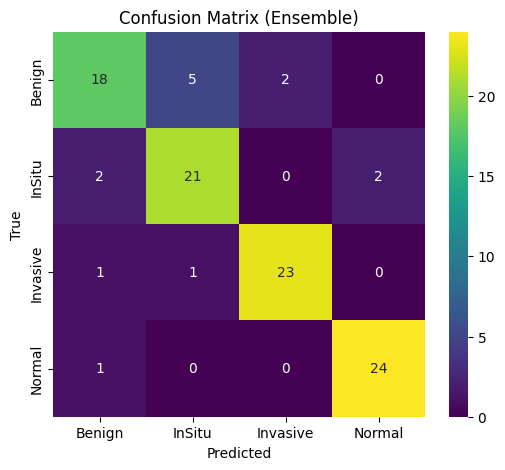

In [22]:
# Cell 17: Ensemble by averaging probabilities (simple soft-voting)
ensemble_probs = (vit_probs + eff_probs) / 2.0
ensemble_preds = ensemble_probs.argmax(axis=1)
print("Ensemble accuracy:", (ensemble_preds==labels).mean())

print("\nClassification report (ensemble):")
print(classification_report(labels, ensemble_preds, target_names=train_ds.classes, digits=4))

# confusion matrix
cm = confusion_matrix(labels, ensemble_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.classes, yticklabels=train_ds.classes, cmap="viridis")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Ensemble)")
plt.show()


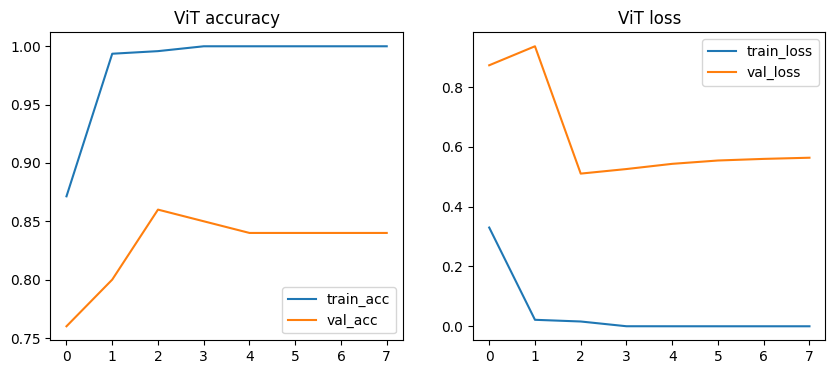

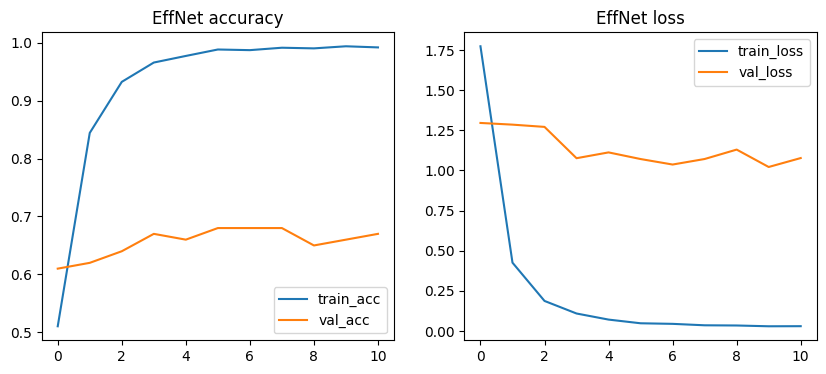

In [23]:
# Cell 18: Plot training curves (ViT + EffNet)
def plot_hist(hist, name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.title(f"{name} accuracy"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{name} loss"); plt.legend()
    plt.show()

plot_hist(vit_hist, "ViT")
plot_hist(eff_hist, "EffNet")
